### Agent Reflection
Agent Reflection is a process where an AI agent reviews its own actions, decisions, and outcomes to improve its performance over time. This involves analyzing past interactions, identifying areas for improvement, and making adjustments to strategies or behaviors.

#spanish
### Reflexión del Agente
La Reflexión del Agente es un proceso en el que un agente de IA revisa sus propias acciones, decisiones y resultados para mejorar su rendimiento con el tiempo. Esto implica analizar interacciones pasadas, identificar áreas de mejora y hacer ajustes en estrategias o comportamientos.


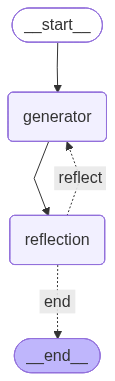

In [1]:
import os 
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage 
from langgraph.graph import StateGraph, MessagesState, START, END 
from typing import Literal, TypedDict, List
from IPython.display import Image, display



load_dotenv()

llm = init_chat_model(model="gpt-4o-mini", 
                          model_provider="openai",
                          max_tokens=200,
                          temperature=0.7,
                          top_p=0.9)

class ReflectionState(MessagesState):
    draft: str = "" #Borrador actual
    reflection: str = "" #Feedback del critico
    iterations: int = 0 #Numero de iteraciones realizadas
    max_iterations: int = 3 #maximo de iteraciones permitidas 
    


"""Nodo que crea o mejor el contenido"""
def generator_node(state:ReflectionState):
    """Generator Node - "El escritor del sistema
    Responsabilidades:
    - Generar contenido inicial 
    - Mejorar Contendio basandose en el feedback 
    - Producir respuesta de calidad 
    
    """
  

    if state.get("reflection"):
        prompt = f"""
         Tarea : Mejorar el siguiente contenido

         CONTENIDO ACTUAL: {state['draft']}
         FEEDBACK RECIBIDO: {state['reflection']}
         SOLICITUD ORIGINAL: {state['messages'][-1].content}

         Genera una version mejorada que aborde todos los puntos del feedback 
        """
    else:
        prompt = f"""
         TAREA: Generar contenido de alta calidad 
         SOLICITUD: {state['messages'][-1].content} 
         Crea una respuesta completa, clara y util
        """

    response = llm.invoke([HumanMessage(content=prompt)])
    print(f"Response Generator Node : {response.content}")

    return {
        "draft": response.content,
        "iterations": state.get("iterations",0) + 1
    }

def reflection_node(state: ReflectionState):
    """ Reflectio Node - El critico del sistema 
        Responsabilidades :
        - Analizar el contenido generado 
        - Identificar areas de mejora 
        - Proporcionar feedback constructivo
    """
    
    
    prompt = f"""
       Eres un critico experto que evalua el contenido 
       
       CONTENIDO A EVALUAR 
       {state['draft']}
       
       SOLICITUD ORIGINAL:
       {state['messages'][-1].content}
       
       Analiza el contenido y proporciona el feedback constructivo
       1- Claridad y estructura 
       2- Completitud de la respuesta 
       3- Precision tecnica 
       4- Areas especificas de mejora 
       
       Si el contenido es excelente, indica "APROBADO - El contenido cumple todos los criterios 
       Si necesitas mejoras, proporciona puntos especificos a mejorar
    """
    
    response = llm.invoke([HumanMessage(content=prompt)])
    
    print(f"Response reflection node : {response.content}")
    return {
        "reflection": response.content,
        "messages": state["messages"]
    } 
    
    
def should_continue_reflection(state: ReflectionState) -> Literal["reflect","end"]:
    """ Decide si continuar refinando o terminar
    
    Criterios:
     - Si alcanzo max_iterations -> terminar 
     - Si el feedback indica "Aprobado" ->terminar
     - De lo contrario -> continuar reflexionando  
    """    
    
    #Verifica limite de iteraciones
    if state.get('iterations',0) >= state.get('max_iterations',3):
        print(f"Limite de iteraciones alcanzado ({state['iterations']})")
        return "end"
    
    if state.get("reflection") and "APROBADO" in state.get("reflection"):
        print(f"Contenido aprobado en interacion : {state["iterations"]}")
        return "end"
    
    print(f"Iteracion {state['iterations']}: Refinando contenido...")
    return "reflect"

  
graph = StateGraph(ReflectionState)

graph.add_node("generator",generator_node)
graph.add_node("reflection",reflection_node)

graph.add_edge(START, "generator")
graph.add_edge("generator","reflection")
graph.add_conditional_edges(
    "reflection",
    should_continue_reflection,
    {
        "end":END,
        "reflect":"generator"
    }
)


from IPython.display import Image, display

# Compilar el grafo
reflection_graph = graph.compile()


try:
    display(Image(reflection_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al generar imagen: {e}")
    # Alternativa: mostrar diagrama como texto
    print(reflection_graph.get_graph().draw_mermaid())
    
    




In [2]:
## Explicar sobre codigo de python 
state:ReflectionState = {
    "messages": HumanMessage(content="Explicame sobre python"),
    "draft":"",
    "reflection":"",
    "iterations": 0,
    "max_iterations":1
}

response = reflection_graph.invoke(state)

print(f"resultado == \n")
print(response)

Response Generator Node : ### Introducción a Python

Python es un lenguaje de programación de alto nivel, interpretado y de propósito general, que se ha vuelto extremadamente popular en diversas áreas como el desarrollo web, la ciencia de datos, la inteligencia artificial, la automatización y más. Fue creado por Guido van Rossum y su primera versión fue lanzada en 1991. Desde entonces, ha evolucionado y se ha convertido en uno de los lenguajes más utilizados en el mundo.

### Características Principales

1. **Simplicidad y Legibilidad**: Python está diseñado para ser fácil de leer y escribir. Su sintaxis es clara y concisa, lo que lo hace ideal para principiantes y para aquellos que buscan desarrollar rápidamente prototipos y aplicaciones.

2. **Multiparadigma**: Python soporta múltiples paradigmas de programación, incluyendo programación orientada a objetos, programación imperativa y programación funcional. Esto permite a los desarrolladores elegir el enfoque que mejor se adapte a sus

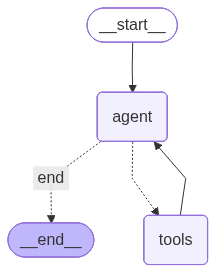

In [12]:
### Tool Use pattern
import os 
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode 
from typing import Literal, TypedDict , List, Annotated
import requests
import math 




@tool
def calculadora(expression: str) -> str:
    """
    Realiza cálculos matemáticos simples.
    
    Args:
        expression: Expresión matemática como string (ej: "2+2", "10*5", "sqrt(16)")
    
    Returns:
        Resultado del cálculo
    """
    try:
        # Permitir funciones matemáticas básicas
        allowed_names = {
            k: v for k, v in math.__dict__.items() if not k.startswith("__")
        }
        allowed_names.update({"abs": abs, "round": round})
        
        result = eval(expression, {"__builtins__": {}}, allowed_names)
        return f"Resultado: {result}"
    except Exception as e:
        return f"Error en el cálculo: {str(e)}"


@tool
def buscar_informacion(query:str) ->str:
    """ funcion que permite realizar un simulador de busqueda"""
    knowledge_base = {
        "python": "Python es un lenguaje de programación de alto nivel, interpretado y de propósito general.",
        "machine learning": "Machine Learning es una rama de la IA que permite a las computadoras aprender sin ser programadas explícitamente.",
        "langgraph": "LangGraph es una librería para construir aplicaciones con agentes usando grafos de estado.",
        "openai": "OpenAI es una empresa de investigación en IA que desarrolló GPT y ChatGPT."
    }

    query_lower = query.lower()
    for key, value in knowledge_base.items():
        if key in query_lower:
            return f"Informacion sobre {query}: {value}"

    return f"No se encontro la informacion especifica sobre la consulta"
@tool 
def contar_caracteres(text:str) -> str:
    """ Node que se encarga de contar caracteres de una palabra"""
    palabras = len(text.split())
    caracteres = len(palabras)
    caracteres_sin_espacio = len(text.replace(" ",""))
    return f"""Analisis del texto:
    - Palabras: {palabras}
    - Caracteres: {caracteres}
    - Caracteres sin espacio: {caracteres_sin_espacio}
    """


tools = [contar_caracteres, buscar_informacion, calculadora]

class ToolState(MessagesState):
    """Estado que incluye capacidad de usar herramientas"""
    pass 


llm = init_chat_model(
        model="gpt-4o-mini", 
        model_provider="openai",
        max_tokens=300
    ).bind_tools(tools) 

def agent_node(state: ToolState):
    """
    Agent que decide si necesita usar herramientas 
    """
   

    system_prompt = """
    Eres un asistente útil que puede usar herramientas para ayudar a los usuarios.
    
    Herramientas disponibles:
    - calculadora: Para realizar cálculos matemáticos
    - buscar_informacion: Para buscar información sobre temas
    - contador_palabras: Para analizar textos
    
    Usa las herramientas cuando sea necesario para responder mejor a las preguntas.
    """
    
    
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages":[response]}


def should_continue(state:ToolState) -> Literal["tools","end"]:
    """Decide si usar herramienta o terminar """

    last_message = state["messages"][-1]
    if hasattr(last_message,'tool_calls') and last_message.tool_calls:
        return "tools"
    
    return "end"

graph = StateGraph(ToolState)
graph.add_node("agent",agent_node)
graph.add_node("tools",ToolNode(tools))

graph.add_edge(START, "agent")
graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "end":END,
        "tools":"tools"
    }
)
graph.add_edge("tools","agent")

build = graph.compile()

from IPython.display import Image, display



try:
    display(Image(build.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al generar imagen: {e}")
    # Alternativa: mostrar diagrama como texto
    print(build.get_graph().draw_mermaid())
    





In [ ]:
test_cases = [
  "Necisito sumar 2 numero 2 +3 ",
  "Realizar una busqueda sobre langchain",
  "Necesito contar los caracteres de la palabra 'cuchara'"
]

for i, question in enumerate(test_cases, 1):
    result = build.invoke({
        "messages": [HumanMessage(content=question)]  # ✅ Lista de mensajes
    })
    print(f"\n Salida : {result["messages"][-1].content}")
    final_message = result["messages"][-1]
    for m2 in result["messages"]:
        m2.pretty_print()
    print(f"🤖 Respuesta: {final_message.content}")


 Salida : La suma de 2 + 3 es 5.
================================ Human Message =================================

Necisito sumar 2 numero 2 +3 
================================== Ai Message ==================================
Tool Calls:
  calculadora (call_6iRY6bldjCvHZN2WNbzPdxxg)
 Call ID: call_6iRY6bldjCvHZN2WNbzPdxxg
  Args:
    expression: 2+3
================================= Tool Message =================================
Name: calculadora

Resultado: 5
================================== Ai Message ==================================

La suma de 2 + 3 es 5.
🤖 Respuesta: La suma de 2 + 3 es 5.

 Salida : Parece que no se encontró información específica sobre "langchain". Sin embargo, puedo ofrecerte un resumen general. LangChain es una biblioteca diseñada para facilitar la creación de aplicaciones que integran modelos de lenguaje. Esta biblioteca permite a los desarrolladores construir flujos de trabajo complejos que interaccionan con APIs, bases de datos y otros componentes, apr